# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science:  Spotify Final Project



**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader<br/>
**Group Members**: Tejal Patwardhan, Akshitha Ramachandran, Grace Zhang
<hr style="height:2pt">

In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [40]:
# import necessary notebooks
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score

from pandas.plotting import scatter_matrix

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

import random

%matplotlib inline

<hr style="height:2pt">

# Data Collection and Cleaning

We collected our data by using the Spotify API to create a json file of tracks and their features, additionally labelling each track with a new feature we introduced, `in_playlist`, which equals 1 if Person X would include the track in her playlist and 0 if Person X would not include the track in her playlist. 

We accomplished this by manually creating 2 separate playlists, where one playlist includes random songs that Person X would include in her playlist and the other playlist includes random songs that Person X would not include in her playlist. We used the Spotify API `user_playlist_tracks` endpoint to collect some features, including `track_id`s, of the tracks in each of these playlists. We then used the `audio_features` endpoint of the Spotify API to get additional features like `danceability`, etc. for each of our tracks. Finally, we added the `in_playlist` feature to each of our tracks and wrote our final object to `spotify.json`.


In [ ]:
import sys
import spotipy
import spotipy.util as util
import json
from math import ceil

scope = 'user-library-read'
LIMIT = 50
PLAYLIST_1_LEN = 163
PLAYLIST_0_LEN = 897

def get_track_features_offset(playlist_id, offset, in_playlist):
    results = sp.user_playlist_tracks(
        'UroAv2poQoWSvUOfch8wmg', 
        playlist_id=playlist_id,
        limit=LIMIT,
        offset=offset,
    )
    track_infos = []
    for i in results['items']:
        track_infos.append({
            'id': i['track']['id'],
            'name': i['track']['name'],
            'popularity': i['track']['popularity'],
            'artist': i['track']['artists'][0]['name'] if len(i['track']['artists']) > 0 else None,
        })
    track_ids = [i['id'] for i in track_infos]

    tracks_features = sp.audio_features(track_ids)
    for idx, track in enumerate(tracks_features):
        track['name'] = track_infos[idx]['name']
        track['popularity'] = track_infos[idx]['popularity']
        track['artist'] = track_infos[idx]['artist']
        track['in_playlist'] = in_playlist
    return tracks_features

def get_track_features(playlist_id, num_iters, in_playlist):
    track_features = []
    for i in range(num_iters):
        track_features.extend(
            get_track_features_offset(playlist_id, i * LIMIT, in_playlist)
        )
    return track_features


# Setup
if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()
token = util.prompt_for_user_token(username, scope)
if not token: 
    print("Can't get token for", username)

sp = spotipy.Spotify(auth=token)

# Get track features
n_playlist0 = ceil(PLAYLIST_0_LEN / LIMIT)
n_playlist1 = ceil(PLAYLIST_1_LEN / LIMIT)

tracks_features0 = get_track_features('4B3qR5p6PD8nXXeq4C0Gz7', n_playlist0, 0)
tracks_features1 = get_track_features('6Jpt5r9KD8FEUDioBFV0r0', n_playlist1, 1)
tracks_features = tracks_features0 + tracks_features1

with open('spotify.json', mode='w') as f:
    f.write(json.dumps(tracks_features, indent=2))

<hr style="height:2pt">

# Data Description
Our data includes the following features:
- `danceability`: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. 
- `energy`: Energy represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. A value of 0.0 is least energetic and 1.0 is most energetic. 
- `key`: The estimated overall key of the track. Integers map to pitches using standard Pitch Class Notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
- `loudness`: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values range between -60 and 0 db. 
- `mode`: Mode represents the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Mode is binary; major is represented by 1 and minor is 0.
- `speechiness`: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- `acousticness`: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. instrumentalness: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- `liveness`: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. 
- `valence`: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- `tempo`: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 
- `duration_ms`: The duration of the track in milliseconds.
- `time_signature`: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).
- `popularity`: The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. 
- `in_playlist`: Response variable. Categorical variable for whether in playlist of desire. 1 if in playlist, 0 if not in playlist.

The following features were recorded to help with visualization later, but not used as predictors in our analysis, as they are not characteristics of the music itself.
- `name`: Song title
- `artist`: First artist of song
- `type`: The object type: “audio_features”
- `id`: The Spotify ID for the track.
- `uri`: The Spotify URI for the track.
- `track_href`: A link to the Web API endpoint providing full details of the track.
- `analysis_url`: An HTTP URL to access the full audio analysis of this track. An access token is required to access this data.

# Exploratory Data Analysis

In [4]:
random.seed(1)

In [5]:
# load in dataset
spotify_df = pd.read_csv("data/spotify.csv")

# drop unnecessary columns
spotify_df = spotify_df.drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'name', 'artist'])

In [6]:
# display head of data
display(spotify_df.head())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity,in_playlist
0,0.516,0.0663,7,-19.221,0,0.0334,0.929,0.000972,0.1120,0.278,109.879,138760,4,11,0
1,0.454,0.2600,8,-13.193,0,0.0401,0.539,0.000780,0.0675,0.598,174.322,324133,5,63,0
2,0.676,0.4400,0,-11.960,1,0.0291,0.360,0.000069,0.1620,0.499,80.434,205773,4,59,0
3,0.466,0.0718,0,-17.999,1,0.0374,0.984,0.000931,0.1070,0.196,121.885,294307,4,56,0
4,0.496,0.6340,5,-10.328,0,0.0364,0.779,0.402000,0.0746,0.606,93.357,423573,4,60,0


In [7]:
# display shape of data
display(spotify_df.shape)

(1381, 15)

We have 1060 songs in our initial analysis. 163 are included in our playlist, and 897 are not included in our playlist. 

In [8]:
# generate summary chart of features
features = []
means = []
var = []
ranges = []
mins = []
maxes = []

for feature in spotify_df:
    if feature != "in_playlist":
        features.append(feature)
        means.append(spotify_df[feature].mean())
        var.append(spotify_df[feature].var())
        ranges.append(spotify_df[feature].ptp())
        mins.append(spotify_df[feature].min())
        maxes.append(spotify_df[feature].max())

summary_df = pd.DataFrame(data = {'feature': features, 
                                  'mean': means,
                                  'var' : var,
                                  'range': ranges, 
                                  'min': mins, 
                                  'max': maxes}) 

Below are summary statistics for all the features we plan to analyze:

In [9]:
display(summary_df)

,feature,mean,var,range,min,max
0,danceability,0.599851,2.773644e-02,8.896000e-01,0.070400,0.960
1,energy,0.435673,7.072625e-02,9.661700e-01,0.001830,0.968
2,key,5.227371,1.289899e+01,1.100000e+01,0.000000,11.000
3,loudness,-10.945238,4.299427e+01,4.066000e+01,-42.320000,-1.660
4,mode,0.629254,2.334624e-01,1.000000e+00,0.000000,1.000
5,speechiness,0.076683,6.056448e-03,7.168000e-01,0.023200,0.740
6,acousticness,0.515712,1.322973e-01,9.959580e-01,0.000042,0.996
7,instrumentalness,0.216039,1.324333e-01,9.870000e-01,0.000000,0.987
8,liveness,0.154902,1.596233e-02,9.598000e-01,0.021200,0.981
9,valence,0.472788,6.430979e-02,9.542000e-01,0.030800,0.985


We can see that all features have values that are expected as per the Spotify API documentation. To analyze each feature in more granularity we looked at density plots. 

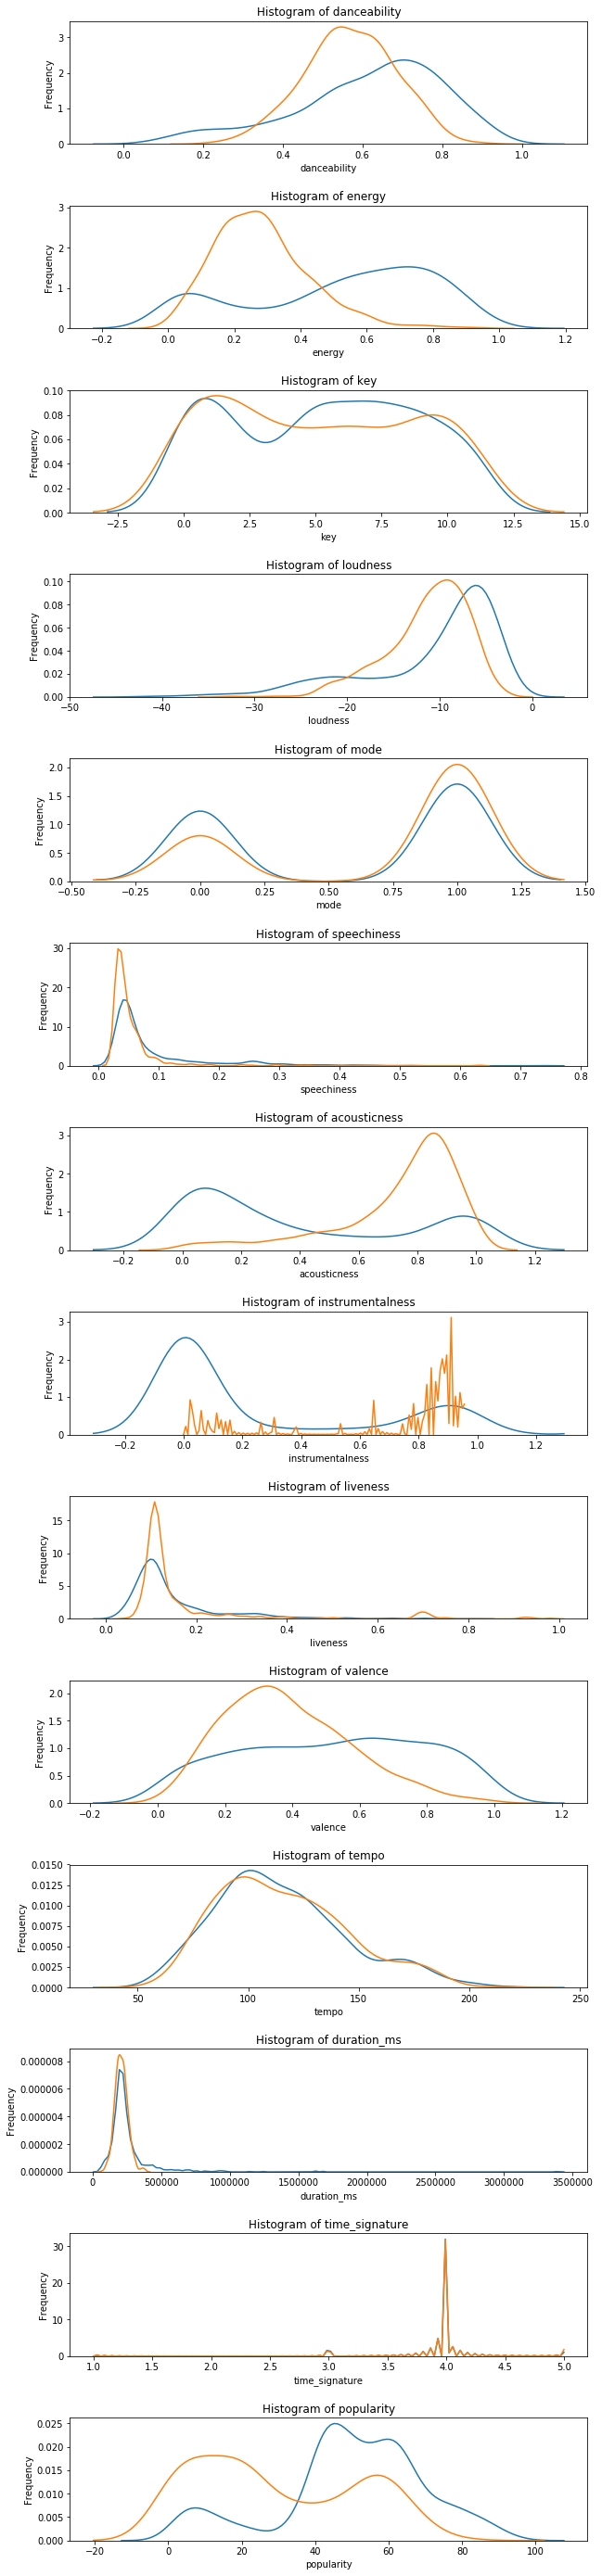

In [10]:
num_cols = len(spotify_df.columns)
nbin = 15

# iterate through all the features and display them
fig, axs = plt.subplots(num_cols - 1,1, figsize=(10,50))
for i in range(num_cols - 1):
    sns.distplot(spotify_df[spotify_df.in_playlist == 0][spotify_df.columns[i]], hist = False, kde = True, ax=axs[i])
    sns.distplot(spotify_df[spotify_df.in_playlist == 1][spotify_df.columns[i]], hist = False, kde = True, ax=axs[i])
    axs[i].set_title("Histogram of " + str(spotify_df.columns[i]))
    axs[i].set_ylabel(r'Frequency')
fig.subplots_adjust(hspace=.5)
plt.show()

Looking at the density plots above, we note some features that show clear differences in distribution between the playlist and non-playlist. 
While non-playlist songs contain a roughly uniform distribution of energy values, playlist songs spike at an energy level between 0.2-0.4.
Acousticness in playlist tracks is much higher on average, spiking around 0.8, while non-playlist tracks most frequently have acousticness values around 0.1.
Instrumentalness is a particularly interesting feature. While the distribution non-playlist tracks is bimodal, peaking at around 0 and 0.9, playlist tracks have a few very well-defined peaks between 0 and 0.3. 
We will note in advance that this may induce a risk of overfitting based on instrumentalness values.
Playlist tracks have lower loudnesses on average, centering around -10, while non-playlist tracks -5.
In terms of speechiness, the distribution for playlist tracks has a much lower variance and slightly lower expected value, centering around 0.3 while non-playlist tracks center around 0.4.
Valence for non-playlist tracks is roughly uniformly distributed, while playlist tracks demonstrate a roughly normal distribution centered around 0.3.
Finally in terms of popularity, playlist tracks show a peak in their distribution around 60, while non-playlist tracks have a more variable distribution with a peak between 45-55.
The rest of the features are roughly similar in distribution between playlist and non-playlist tracks.

# Baseline Model

In [71]:
# set response
response_col = 'in_playlist'

# split into train and test
train, test = train_test_split(spotify_df, test_size = 0.2)
x_train, y_train = train.drop(columns=[response_col]), train[response_col].values
x_test, y_test = test.drop(columns=[response_col]), test[response_col].values

# create logistic model
log_reg_model = LogisticRegression(C=100000, fit_intercept=False)
log_reg_model.fit(x_train, y_train)

# predict
log_reg_train_predictions = log_reg_model.predict(x_train)
log_reg_test_predictions = log_reg_model.predict(x_test)

# calculate scores
log_reg_train_score = accuracy_score(y_train, log_reg_train_predictions)
log_reg_test_score = accuracy_score(y_test, log_reg_test_predictions)

# display scores
print('Classification accuracy for train set: {}'.format(log_reg_train_score))
print('Classification accuracy for test set: {}'.format(log_reg_test_score))

Classification accuracy for train set: 0.7327898550724637
Classification accuracy for test set: 0.7653429602888087


Our baseline logistic model is able to achieve an accuracy of 85% in the training set, and 82% in the test set.

# Moving Forward

So far, everything is running smoothly. We have access to the Spotify data we want, and as confirmed with Pavlos, this analysis can now be used to create the logistic and neural network models we listed in Milestone 2. Our EDA suggests that there are quite a few features that show promise of distinguishing between playlist and non-playlist songs. Our baseline model also works decently well, scoring an 82% accuracy in our test set. Next, we will build upon our baseline model. We will add in stepwise variable selection, ridge variable selection, lasso variable selection, interaction terms, and higher-degree polynomial terms. Then, we will create a neural network as an alternative method to classify playlist songs. We will then analyze the models and comment on their differences, similarities, what works, and what doesn't. Finally, we will upload everything to a website for clean reporting.


Revised question: How can we best create a model to predict which songs should be added to Person X's playlist?

# Decision Trees

In [72]:
# classify by depth
def treeClassifierByDepth(depth, x_train, y_train, cvt = 5):
    model = DecisionTreeClassifier(max_depth=depth).fit(x_train, y_train)
    return cross_val_score(model, x_train, y_train, cv = cvt)

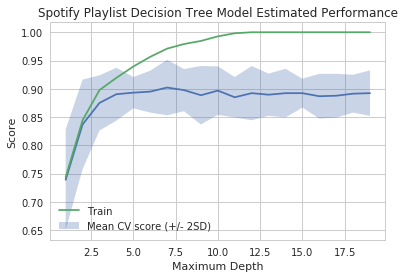

In [73]:
# 5-fold CV
means = []
lower = []
upper = []
sds = []
trains = []
for i in range(1, 20):
    # fit model
    tc = treeClassifierByDepth(i, x_train, y_train)
    # calc mean and sd
    cur_mean = np.mean(tc)
    cur_sd = np.std(tc)
    train_val = DecisionTreeClassifier(max_depth=i).fit(x_train, y_train).score(x_train,y_train)
    # add to lists
    trains.append(train_val)
    means.append(cur_mean)
    lower.append(cur_mean - 2*cur_sd)
    upper.append(cur_mean + 2*cur_sd)
    
plt.plot(range(1,20),means)
plt.fill_between(range(1,20), lower, upper, alpha = 0.3, label = "Mean CV score (+/- 2SD)")
plt.plot(range(1,20), trains, label="Train")
plt.title("Spotify Playlist Decision Tree Model Estimated Performance")
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

In [74]:
# cross validation performance
train_score = means[4]
print("Mean classification accuracy (train): ",train_score)
print("Mean +/- 2 SD: (", lower[4],",",upper[4],")")

Mean classification accuracy (train):  0.8930884483825661
Mean +/- 2 SD: ( 0.8653867798847602 , 0.9207901168803719 )


We achieve the best cross-validated score at a tree depth of $5$. Additionally, it had a narrow spread in estimated performances.

In [75]:
# test set performance
model_dec_tree = DecisionTreeClassifier(max_depth=5).fit(x_train, y_train)
test_score = model_dec_tree.score(x_test, y_test)
print("Test set classification accuracy: ", test_score)

Test set classification accuracy:  0.9205776173285198


We see that it performs just as well against the training data with an accuracy score of $0.91$.

# Bootstrapping

Create 45 bootstrapped datasets, fitting a decision tree to each of them and saving their predictions:

In [76]:
# bootstrap
new_depth = 5
num_trees = 45
bagging_train_arr = []
bagging_test_arr = []
estimators = []

tree_res = []

tree = DecisionTreeClassifier(max_depth=new_depth)

# classify train and test with bootstrap models
for i in range(num_trees):
    boot_x, boot_y = resample(x_train, y_train)
    fit_tree = tree.fit(boot_x, boot_y)
    estimators.append(fit_tree)
    bagging_train_arr.append(tree.predict(x_train))
    bagging_test_arr.append(tree.predict(x_test))

Construct dataframs with all the bootstrapped data:

In [77]:
# train
bagging_train = pd.DataFrame()
for i in range(len(bagging_train_arr)):
    col_name = "Bootstrap Model " + str(i + 1)
    bagging_train[col_name] = bagging_train_arr[i]

# test
bagging_test = pd.DataFrame()
for i in range(len(bagging_test_arr)):
    col_name = "Bootstrap Model " + str(i + 1)
    bagging_test[col_name] = bagging_test_arr[i]
    
# generate renaming row obj
rename = {}

for i in range(0, 1104):
    rename[i] = "Training Row " + str(i + 1)


bagging_train.rename(rename, inplace=True)
bagging_test.rename(rename,  inplace=True)

display(bagging_train.head())
display(bagging_test.head())

,Bootstrap Model 1,Bootstrap Model 2,Bootstrap Model 3,Bootstrap Model 4,Bootstrap Model 5,Bootstrap Model 6,Bootstrap Model 7,Bootstrap Model 8,Bootstrap Model 9,Bootstrap Model 10,Bootstrap Model 11,Bootstrap Model 12,Bootstrap Model 13,Bootstrap Model 14,Bootstrap Model 15,Bootstrap Model 16,Bootstrap Model 17,Bootstrap Model 18,Bootstrap Model 19,Bootstrap Model 20,Bootstrap Model 21,Bootstrap Model 22,Bootstrap Model 23,Bootstrap Model 24,Bootstrap Model 25,Bootstrap Model 26,Bootstrap Model 27,Bootstrap Model 28,Bootstrap Model 29,Bootstrap Model 30,Bootstrap Model 31,Bootstrap Model 32,Bootstrap Model 33,Bootstrap Model 34,Bootstrap Model 35,Bootstrap Model 36,Bootstrap Model 37,Bootstrap Model 38,Bootstrap Model 39,Bootstrap Model 40,Bootstrap Model 41,Bootstrap Model 42,Bootstrap Model 43,Bootstrap Model 44,Bootstrap Model 45
Training Row 1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Training Row 2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Training Row 3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Training Row 4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1
Training Row 5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,Bootstrap Model 1,Bootstrap Model 2,Bootstrap Model 3,Bootstrap Model 4,Bootstrap Model 5,Bootstrap Model 6,Bootstrap Model 7,Bootstrap Model 8,Bootstrap Model 9,Bootstrap Model 10,Bootstrap Model 11,Bootstrap Model 12,Bootstrap Model 13,Bootstrap Model 14,Bootstrap Model 15,Bootstrap Model 16,Bootstrap Model 17,Bootstrap Model 18,Bootstrap Model 19,Bootstrap Model 20,Bootstrap Model 21,Bootstrap Model 22,Bootstrap Model 23,Bootstrap Model 24,Bootstrap Model 25,Bootstrap Model 26,Bootstrap Model 27,Bootstrap Model 28,Bootstrap Model 29,Bootstrap Model 30,Bootstrap Model 31,Bootstrap Model 32,Bootstrap Model 33,Bootstrap Model 34,Bootstrap Model 35,Bootstrap Model 36,Bootstrap Model 37,Bootstrap Model 38,Bootstrap Model 39,Bootstrap Model 40,Bootstrap Model 41,Bootstrap Model 42,Bootstrap Model 43,Bootstrap Model 44,Bootstrap Model 45
Training Row 1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0,1,1,1,0,1,1,0,1,0,1,1,0
Training Row 2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
Training Row 3,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,1,1,1
Training Row 4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Training Row 5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [82]:
# your code here
y_preds_train = []
y_preds_test = []

for row in bagging_train.iterrows():
    if np.mean(row[1]) > 0.5:
        y_preds_train.append(1)
    else:
        y_preds_train.append(0)

for row in bagging_test.iterrows():
    if np.mean(row[1]) > 0.5:
        y_preds_test.append(1)
    else:
        y_preds_test.append(0)
        
def compare_acc(preds, actual):
    count = 0
    for i in range(len(preds)):
        if preds[i] == actual.item(i):
            count += 1
    return(count/len(preds))

bagging_train_score = compare_acc(y_preds_train,y_train)
bagging_test_score = compare_acc(y_preds_test,y_test)

print("Training Accuracy: ", bagging_train_score)
print("Test Accuracy: ", bagging_train_score)

Training Accuracy:  0.957427536231884
Test Accuracy:  0.957427536231884


# Random Forrest

In [87]:
# model random forest
model_rf = RandomForestClassifier(n_estimators=num_trees, max_depth=new_depth)

# fit model on X_train data
model_rf.fit(x_train, y_train)

# predict using model
y_pred_train_rf = model_rf.predict(x_train)
y_pred_test_rf = model_rf.predict(x_test)

# accuracy from train and test
train_score_rf = accuracy_score(y_train, y_pred_train_rf)
test_score_rf = accuracy_score(y_test, y_pred_test_rf)

# print accuracy scores
print("Random Forest Accuracy, Training Set :",str(train_score_rf)+'%')
print("Random Forest Accuracy, Testing Set :",str(test_score_rf)+'%')

Random Forest Accuracy, Training Set : 0.9501811594202898%
Random Forest Accuracy, Testing Set : 0.9458483754512635%


# Boosting

In [35]:
def boostingClassifier(x_train, y_train, depth):
    # AdaBoostClassifier
    abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth),
                         n_estimators=800, learning_rate = 0.05)
    abc.fit(x_train, y_train)
    # staged_score train to plot
    abc_predicts_train = list(abc.staged_score(x_train,y_train))
    plt.plot(abc_predicts_train, label = "train");

    # staged_score test to plot
    abc_predicts_test = list(abc.staged_score(x_test,y_test))
    plt.plot(abc_predicts_test, label = "test");

    plt.legend()
    plt.title("AdaBoost Classifier Accuracy, n = "+str(depth))
    plt.xlabel("Iterations")
    plt.show()
    
    return("Maximum test accuracy for depth of "+str(depth)+" is "+str(max(abc_predicts_test))+" at "+str(abc_predicts_test.index(max(abc_predicts_test)))+" iterations")

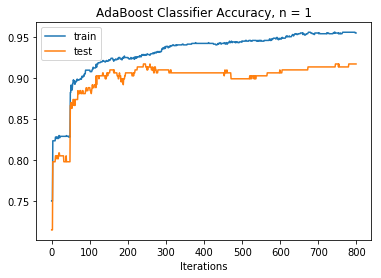

Maximum test accuracy for depth of 1 is 0.9169675090252708 at 241 iterations


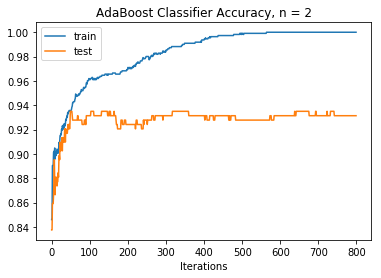

Maximum test accuracy for depth of 2 is 0.9350180505415162 at 49 iterations


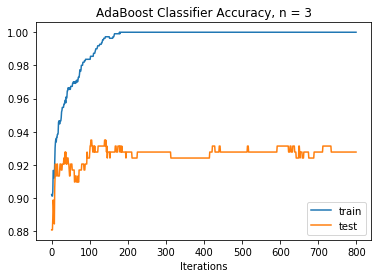

Maximum test accuracy for depth of 3 is 0.9350180505415162 at 103 iterations


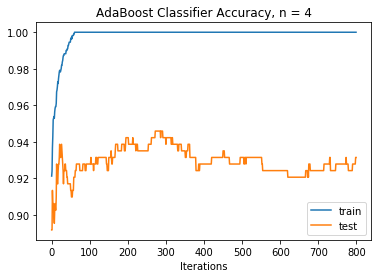

Maximum test accuracy for depth of 4 is 0.9458483754512635 at 272 iterations


In [36]:
for i in range(1,5):
    print(boostingClassifier(x_train, y_train, i))